1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

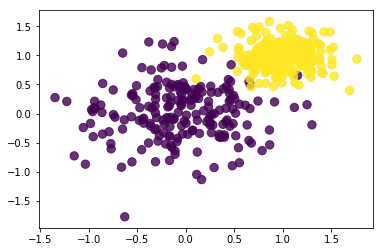

In [1]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

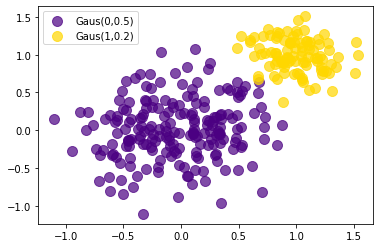

In [29]:
def get_gauss(mean,dev,n):
    a = np.random.normal(loc=mean, scale=dev, size=(2*n,)) 
    return np.reshape(a,(n,2))


g1=get_gauss(0,0.4,200)
g2=get_gauss(1,0.2,100)

fig, ax = plt.subplots()
ax.scatter(x=g1[:,0], y=g1[:,1], c="indigo",alpha=0.7, s=100, label="Gaus(0,0.5)")
ax.scatter(x=g2[:,0], y=g2[:,1], c="gold",alpha=0.7, s=100, label="Gaus(1,0.2)")
plt.legend(loc="upper left")
plt.show()



2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [3]:
url = 'https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl?dl=1'

data_raw = pd.read_pickle(url)
data= pd.DataFrame(data_raw.item())
data
    

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [33]:
data=data[np.abs(data["residuals"])<2]
data

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


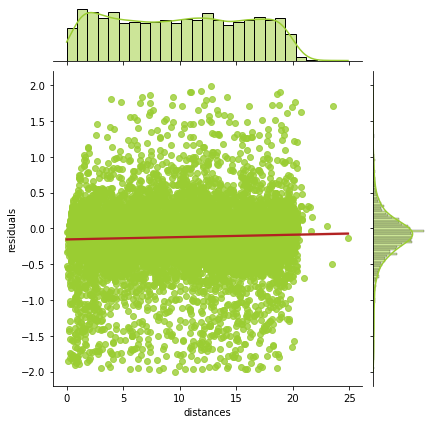

In [49]:
import seaborn as sns

sns.jointplot(x="distances", y="residuals", data=data, kind="reg", color="yellowgreen", joint_kws={'line_kws':{'color':'firebrick'}})

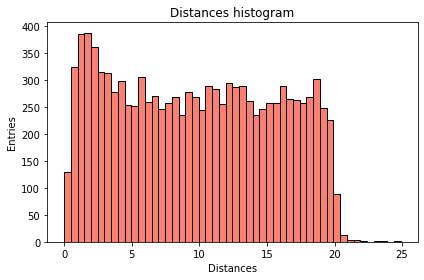

In [41]:
fig, ax = plt.subplots()
h, bins, _ = plt.hist(data["distances"], bins=50, range=(np.min(data["distances"]), np.max(data["distances"])), density=False, cumulative=False, color="salmon", edgecolor='black')
ax.set_title('Distances histogram')
ax.set_xlabel('Distances')  
ax.set_ylabel('Entries')  
fig.tight_layout()

In [43]:
x= (bins[1:]+bins[:-1])/2
y=data.groupby(pd.cut(data['distances'], bins=bins)).mean()["residuals"]
err_y= data.groupby(pd.cut(data['distances'], bins=bins)).std()["residuals"]

print("\n\nx= ", end="")
print(x)
print("\n\ny= ", end="")
print(y)
print("\n\nerr_y= ", end="")
print(err_y)




x= [ 0.249  0.747  1.245  1.743  2.241  2.739  3.237  3.735  4.233  4.731
  5.229  5.727  6.225  6.723  7.221  7.719  8.217  8.715  9.213  9.711
 10.209 10.707 11.205 11.703 12.201 12.699 13.197 13.695 14.193 14.691
 15.189 15.687 16.185 16.683 17.181 17.679 18.177 18.675 19.173 19.671
 20.169 20.667 21.165 21.663 22.161 22.659 23.157 23.655 24.153 24.651]


y= distances
(0.0, 0.498]        -1.294288
(0.498, 0.996]      -1.770694
(0.996, 1.494]      -1.424095
(1.494, 1.992]      -1.113743
(1.992, 2.49]       -0.730890
(2.49, 2.988]       -1.045931
(2.988, 3.486]      -0.975783
(3.486, 3.984]      -0.823403
(3.984, 4.482]      -0.924744
(4.482, 4.98]       -0.427930
(4.98, 5.478]       -0.338510
(5.478, 5.976]      -0.915154
(5.976, 6.474]      -0.352880
(6.474, 6.972]      -0.446871
(6.972, 7.47]       -0.721728
(7.47, 7.968]       -0.638365
(7.968, 8.466]      -0.567518
(8.466, 8.964]      -0.758365
(8.964, 9.462]      -0.584179
(9.462, 9.96]       -0.509820
(9.96, 10.458]      -0.1

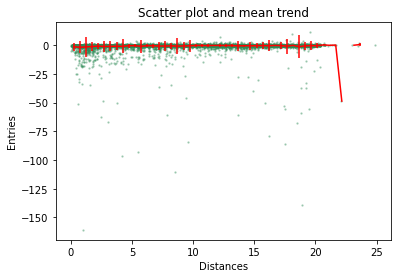

In [55]:
fig, ax = plt.subplots()
ax.scatter(x=data["distances"], y=data["residuals"], c="seagreen",alpha=0.3, s=2)
ax.errorbar(x=x, y=y, yerr=err_y, c="red")
ax.set_title('Scatter plot and mean trend')
ax.set_xlabel('Distances')  
ax.set_ylabel('Entries')  

plt.show()

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


In [3]:
x = np.random.normal(loc=0., scale=1, size=100) 

print(x)

[-2.6534118   1.46163468  0.09553633 -0.66071926  0.1568461   0.5058379
  0.73057993 -1.76951173 -0.04105971  0.49319333 -0.67486515  0.0596122
 -0.98057474 -0.91445781 -0.49337585  1.90711801  0.27300389  0.48756945
  0.02880296  1.34167338 -0.20797621 -1.38962639 -0.33329045  1.07585206
  0.55368661  1.14336136  1.7777081   0.6332372  -0.24393035  0.68943497
 -0.05957785 -0.65312608 -0.83526943 -0.10014441  0.28143816  0.98989732
  1.34791868 -0.77299152 -0.79245756 -0.69587822  0.83441979  2.30122562
  0.6726348   0.6736815   0.74308129 -1.26819764  0.17597924 -0.39710432
 -1.40152001 -0.67399424  0.99068688  1.13140873 -1.07193484 -0.21843833
  1.19413012 -0.03326724 -0.23692358  0.91417365 -0.14201837  0.97969968
  1.01277125  1.65093861  1.71046954 -0.60739674 -1.21559128 -0.82823891
 -1.22433092  0.80693071  0.58241097 -0.01138114 -0.12457856  1.50516688
 -1.19676399 -0.59170129 -0.05552125  0.9302127  -0.06520604 -1.93180517
 -0.50666577 -0.59028183 -0.28949468  0.90412297 -0.4

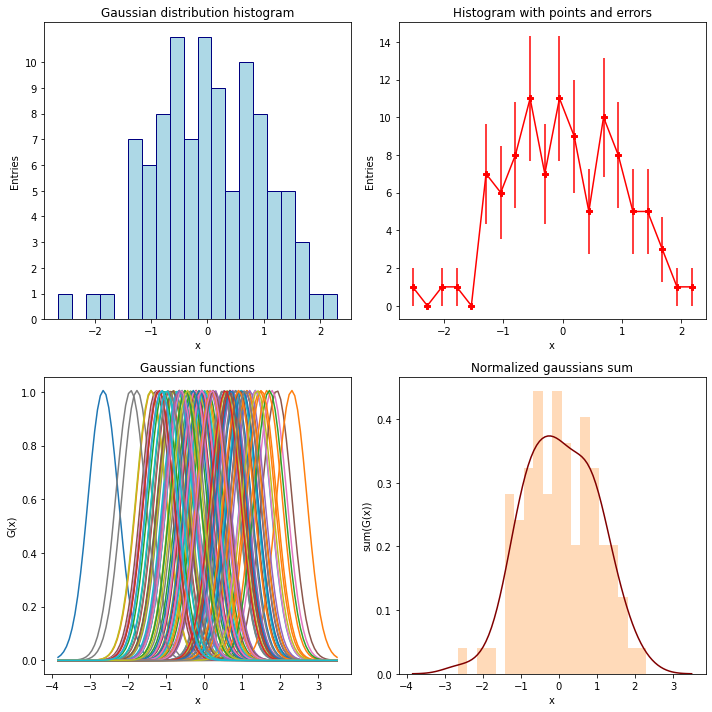

In [7]:
import scipy.stats as stats

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))


#--------1st plot-----------------
h, bins, _ = ax[0,0].hist(x, bins=20, range=(np.min(x), np.max(x)), density=False, cumulative=False, color="lightblue", edgecolor='navy')
ax[0,0].set_title('Gaussian distribution histogram')
ax[0,0].set_xlabel('x')  
ax[0,0].set_ylabel('Entries')  
ax[0,0].set_yticks(np.arange(np.min(h),np.max(h)))


#--------2nd plot----------------
x_bins= (bins[1:]+bins[:-1])/2
ax[0,1].errorbar(x=x_bins, y=h, yerr=np.sqrt(h), c="red", marker="P")
ax[0,1].set_title('Histogram with points and errors')
ax[0,1].set_xlabel('x')  
ax[0,1].set_ylabel('Entries')  


#--------3rd plot----------------
mean=x
std_dev=1.06*np.std(x)*len(x)**(-1/5)
x_points = np.linspace(np.min(mean) - 3*std_dev, np.max(mean) + 3*std_dev, 100)
y_points= np.array([stats.norm.pdf(x_points, mean[i], std_dev) for i in range(len(x)) ])

for i in y_points: ax[1,0].plot(x_points, i)
ax[1,0].set_title('Gaussian functions')
ax[1,0].set_xlabel('x')  
ax[1,0].set_ylabel('G(x)')  


#--------4th plot----------------
sum_y=np.sum(y_points, axis=0)
norm=np.trapz(sum_y, dx=0.07)
sum_y/=norm
ax[1,1].hist(x, bins=20, range=(np.min(x), np.max(x)), density=True, cumulative=False, color="peachpuff")
ax[1,1].plot(x_points, sum_y, color="maroon")
ax[1,1].set_title('Normalized gaussians sum')
ax[1,1].set_xlabel('x')  
ax[1,1].set_ylabel('sum(G(x))') 


fig.tight_layout()
